**Question No.2**. NLP Dataset: Sentiment Analysis dataset - 1.6 Million tweets. 

**Solution Notebook :** 

> # Import Libraries/Dataset

In [1]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.8MB/s 


In [2]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.4.1


In [3]:
# LOADING THE NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow_hub as hub
from tensorflow import keras 
import kerastuner as kt
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
#import transformers

In [4]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2021-05-21 05:17:55--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  14.6MB/s    in 6.9s    

2021-05-21 05:18:02 (11.8 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


In [5]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

# Data Visualization and augmentation 

1. Print at least two tweet from each class of the dataset, for a sanity check that labels match the text.
2. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries)
3. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.
4. Print the shapes of train and test data.

In [6]:
df.head(10)

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [7]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


> Print at least two tweet from each class of the dataset, for a sanity check that labels match the text.

In [8]:
negative_sample=df[df['polarity'] == 0]
negative_sample.iloc[:2]

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [9]:
positive_sample=df[df['polarity'] == 4]
positive_sample.iloc[:2]

,polarity,id,date,query,user,text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...


## Update polarity

Right now the `polarity` column is `0` for negative, `4` for positive. Let's change that to `0` and `1` to make things a little more reasonably readable.

In [10]:
df.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [11]:
df.polarity = df.polarity.replace({0: 0, 4: 1})
df.polarity.value_counts()

1    800000
0    800000
Name: polarity, dtype: int64

         polarity  ...                                               text
800000          1  ...       I LOVE @Health4UandPets u guys r the best!! 
1066651         1  ...  Speaking of texts NO MORE TEXTING TIL JUNE 11....

[2 rows x 6 columns]
        polarity  ...                                               text
0              0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
533328         0  ...  @Barber_21  i've never ever played an instrume...

[2 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



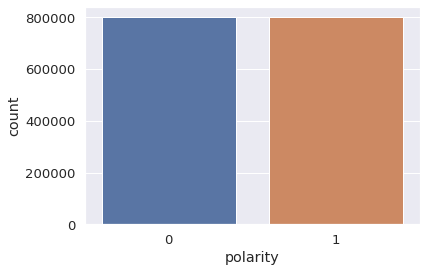

In [12]:
df1 = df.sort_values('polarity',ascending = False).head(2)
print (df1)
df1 = df.sort_values('polarity',ascending = True).head(2)
print (df1)

sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.polarity)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [13]:
np.sum(df.isnull().any(axis=1))

0

## DATA PREPARATION

> remove unwanted columns

In [14]:
df = df.drop(columns=['id', 'date', 'query', 'user'],axis=1)
df.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


> Making statement text in lower case

In [15]:
df['text']=df['text'].str.lower()
df['text'].tail()

1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

> Cleaning and removing Stop words of english

In [16]:
import nltk
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

> Cleaning and removing the above stop words list from the tweet text


In [18]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, behaving all. i'm mad. he...
Name: text, dtype: object

> Cleaning and removing punctuations

In [19]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [20]:
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()

1599995                     woke up school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

> Cleaning and removing repeating characters

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()

1599995                       woke up schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998     hapy 38th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

> Cleaning and removing email

In [22]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

df['text']= df['text'].apply(lambda x: cleaning_email(x))
df['text'].tail()

1599995                       woke up schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998     hapy 38th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

> Cleaning and removing URL's

In [23]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail()

1599995                       woke up schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998     hapy 38th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

> Cleaning and removing Numeric numbers

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].tail()

1599995                       woke up schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998       hapy th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

# **Data Pre-processing**

In [25]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",input_shape=[],dtype=tf.string)
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


In [26]:
df = df.sample(n=100000) # select 100k value because of machine resource constraint 
df.polarity.value_counts()

df.to_csv("data/sentiment140-subset.csv", index=False)

In [27]:
X=df.text
y=df.polarity

> Convert sentences to sequences

In [28]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [29]:
sequences_matrix.shape

(100000, 500)

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((70000, 500), (30000, 500), (70000,), (30000,))

# **Model Building with hyperparameter tuning and without kernel_regularizer**

In [31]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

model_without_reg = tensorflow_based_model() # here we are calling the function of created model
model_without_reg.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  

print('Training model...')
from time import time
start = time()
history = model_without_reg.fit(X_train,Y_train,batch_size=80,epochs=6,validation_data=(X_test, Y_test))
print('Training duration is :')
print(time()-start)
print('Training finished !!')

Training model...
Epoch 1/6
875/875 [==============================] - 338s 385ms/step - loss: 0.5774 - accuracy: 0.6829 - val_loss: 0.5020 - val_accuracy: 0.7545
Epoch 2/6
875/875 [==============================] - 353s 404ms/step - loss: 0.4924 - accuracy: 0.7636 - val_loss: 0.4964 - val_accuracy: 0.7574
Epoch 3/6
875/875 [==============================] - 363s 415ms/step - loss: 0.5005 - accuracy: 0.7538 - val_loss: 0.4938 - val_accuracy: 0.7573
Epoch 4/6
875/875 [==============================] - 343s 392ms/step - loss: 0.4744 - accuracy: 0.7690 - val_loss: 0.4970 - val_accuracy: 0.7584
Epoch 5/6
875/875 [==============================] - 360s 412ms/step - loss: 0.4697 - accuracy: 0.7735 - val_loss: 0.5531 - val_accuracy: 0.7435
Epoch 6/6
875/875 [==============================] - 359s 410ms/step - loss: 0.5132 - accuracy: 0.7542 - val_loss: 0.4954 - val_accuracy: 0.7587
Training duration is :
2116.9596033096313
Training finished !!


In [32]:
accr_without_reg = model_without_reg.evaluate(X_test,Y_test) 
print('Test set\n  Accuracy: {:0.2f}'.format(accr_without_reg[1])) #the accuracy of the model on test data is given below

938/938 [==============================] - 59s 62ms/step - loss: 0.4954 - accuracy: 0.7587
Test set
  Accuracy: 0.76


# **Model Building with hyperparameter tuning with kernel_regularizer**

In [33]:
# in out first run we got 384 as no of hidden units
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Input(name='inputs',shape=[max_len]))
  model.add(keras.layers.Embedding(2000,50,input_length=max_len))
  model.add(keras.layers.LSTM(64))
  model.add(keras.layers.Dense(256,kernel_regularizer='l2'))
  model.add(keras.layers.Activation('relu'))
  hp_dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3, 0.4, 0.5])
  model.add(keras.layers.Dropout(hp_dropout_rate))
  model.add(keras.layers.Dense(1,name='out_layer'))
  model.add(keras.layers.Activation('sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

# **Model Compilation**

In [34]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     hyperband_iterations=2)

tuner.search(X_train,Y_train,
             validation_data=(X_test, Y_test),
             epochs=30,batch_size=80,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 14 Complete [00h 12m 34s]
val_accuracy: 0.5039666891098022

Best val_accuracy So Far: 0.5039666891098022
Total elapsed time: 02h 53m 16s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [35]:
print(f"""
The hyperparameter search is complete. 
the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and value of 
dropout in hidden layer is {best_hps.get('dropout_rate')}.
""")


The hyperparameter search is complete. 
the optimal learning rate for the optimizer
is 0.001 and value of 
dropout in hidden layer is 0.2.



# **Model Training**

In [46]:
print('Training model...')
from time import time

start = time()

model = tuner.hypermodel.build(best_hps)
history_2 = model.fit(X_train,Y_train,batch_size=80,epochs=6,validation_data=(X_test, Y_test))

print('Training duration is :')
print(time()-start)
print('Training finished !!')

Training model...
Epoch 1/6
875/875 [==============================] - 369s 419ms/step - loss: 8.7612 - accuracy: 0.5012 - val_loss: 73.9582 - val_accuracy: 0.5040
Epoch 2/6
875/875 [==============================] - 367s 420ms/step - loss: 118.9586 - accuracy: 0.5004 - val_loss: 296.0261 - val_accuracy: 0.5040
Epoch 3/6
875/875 [==============================] - 364s 416ms/step - loss: 379.5920 - accuracy: 0.5019 - val_loss: 673.5745 - val_accuracy: 0.5040
Epoch 4/6
875/875 [==============================] - 365s 417ms/step - loss: 797.0202 - accuracy: 0.5031 - val_loss: 1212.9230 - val_accuracy: 0.5040
Epoch 5/6
875/875 [==============================] - 364s 416ms/step - loss: 1377.4941 - accuracy: 0.5025 - val_loss: 1918.2136 - val_accuracy: 0.5040
Epoch 6/6
875/875 [==============================] - 366s 419ms/step - loss: 2124.9833 - accuracy: 0.4996 - val_loss: 2792.6917 - val_accuracy: 0.5040
Training duration is :
2195.967384815216
Training finished !!


# **Model Evaluation**

In [47]:
accr1 = model.evaluate(X_test,Y_test) 
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

938/938 [==============================] - 59s 63ms/step - loss: 2792.6743 - accuracy: 0.5040
Test set
  Accuracy: 0.50


# **Prediction**

As the model give probabilties so we are setting a threshold 0.5. More than 0.5 will be the positive tweets and lower will be negative tweets

In [48]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

# **Plot accuracy**

In [49]:
import matplotlib.pyplot as plt

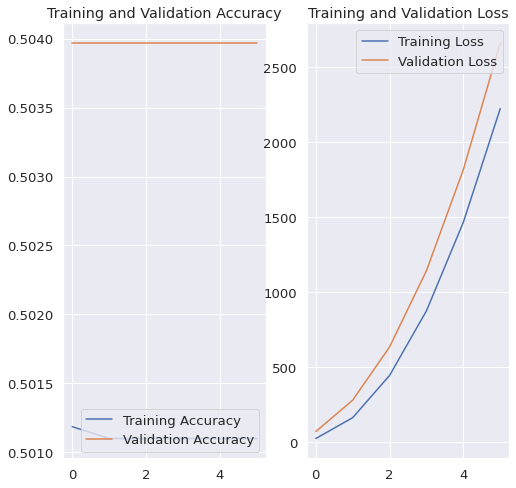

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Confusion Metrics**



confusion matrix


[[15119     0]
 [14881     0]]




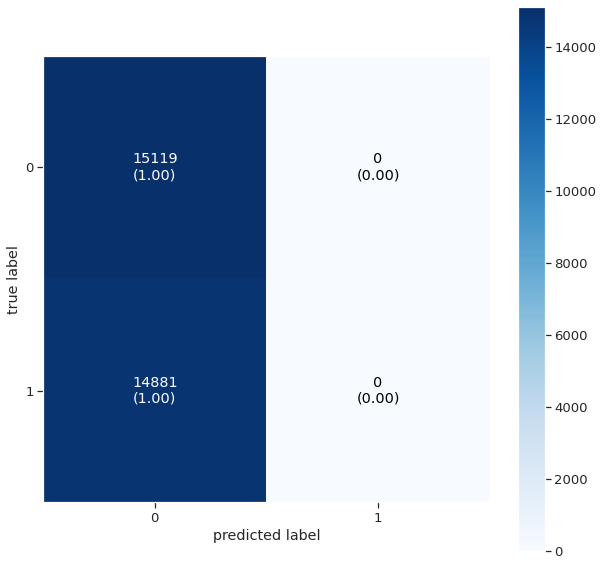

In [41]:
from mlxtend.plotting import plot_confusion_matrix
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# check correctly classified index

In [52]:
p_test = model.predict(X_test).argmax(axis=1)

In [53]:
correctly_classified_idx=np.where(p_test == Y_test)[0]
print(correctly_classified_idx)

[    1     2     4 ... 29991 29994 29997]


# check missclassified index

In [54]:
misclassified_idx = np.where(p_test != Y_test)[0]
print(misclassified_idx)

[    0     3     6 ... 29996 29998 29999]


**Hyperparameter Tuning**- Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model. (1 + 1 = 2 marks)
1. Dropout: Change the position and value of dropout layer
2. Regularization: Train a model without regularization

Answer:

The hyperparameter search is complete. 
the optimal learning rate for the optimizer
is 0.001 and value of 
dropout in hidden layer is 0.2.


# Comparison between model with regulization and without regulization

In [55]:
print(f'accuracy without regulisation is [test loss, test accuracy] :{accr_without_reg} \nand\nwith regulization is [test loss, test accuracy]: {accr1}')

accuracy without regulisation is [test loss, test accuracy] :[0.49536603689193726, 0.7586666941642761] 
and
with regulization is [test loss, test accuracy]: [2792.67431640625, 0.5039666891098022]
